In [1]:
import numpy as np 
from numpy.linalg import qr, svd

from scipy.integrate import solve_ivp
from scipy.linalg import hadamard, subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

from linear_sca import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV, LinearRegression, RidgeCV

import wandb

In [2]:
path = "/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy"

X_raw = np.load(path).swapaxes(1,2)
print(X_raw.shape)
K, N, T = X_raw.shape

X, _ = pre_processing(X_raw, soft_normalize='max')
X_pre_pca, _ = pre_processing(X_raw, soft_normalize='max', pca=False)

(108, 182, 140)


In [3]:
np.mean(compute_S(X))

0.4347857

In [3]:
d=6
wandb.init(project="SCA-project-MC_Maze", name=f"d={d}", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(X,d=d, iterations=5000, seed=0) 
wandb.finish()
#np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/2_6_2024/single spikes/U_psth_{d}d', U)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 3.5165765285491943, S_ratio: 0.34452033042907715
Iteration 10, S: 4.727742671966553, S_ratio: 0.37822020053863525
Iteration 20, S: 4.298886299133301, S_ratio: 0.34684494137763977
Iteration 30, S: 2.927288293838501, S_ratio: 0.30725473165512085
Iteration 40, S: 4.666289329528809, S_ratio: 0.32748764753341675
Iteration 50, S: 3.2122960090637207, S_ratio: 0.3100963234901428
Iteration 60, S: 6.1220903396606445, S_ratio: 0.3589135706424713
Iteration 70, S: 6.695436000823975, S_ratio: 0.39191824197769165
Iteration 80, S: 5.743926525115967, S_ratio: 0.3616279065608978
Iteration 90, S: 8.7213134765625, S_ratio: 0.3867676854133606
Iteration 100, S: 3.9756968021392822, S_ratio: 0.373987078666687
Iteration 110, S: 9.118260383605957, S_ratio: 0.41697245836257935
Iteration 120, S: 6.616594314575195, S_ratio: 0.39752012491226196
Iteration 130, S: 4.957956314086914, S_ratio: 0.342909038066864
Iteration 140, S: 5.747180938720703, S_ratio: 0.4034949243068695
Iteration 150, S: 8.61314678

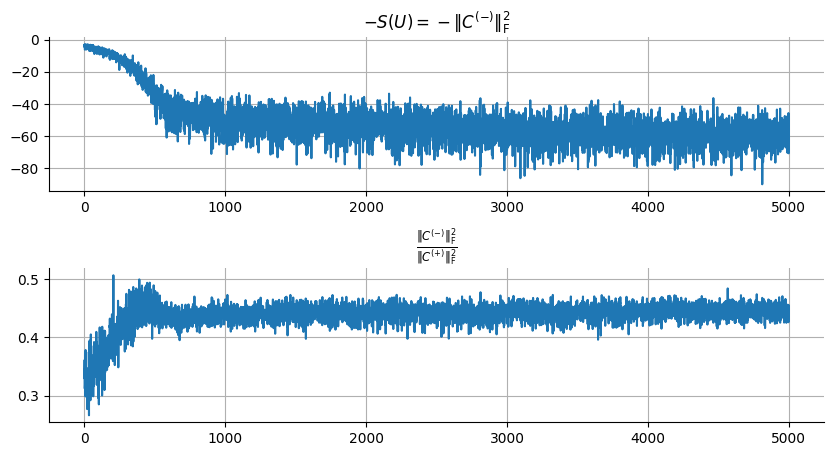

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

Text(0.5, 0.92, 'sca 0.43')

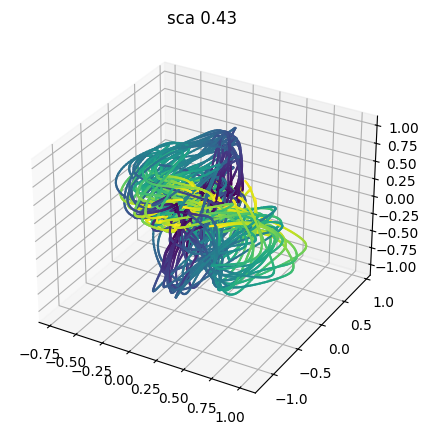

In [5]:
#U = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/outputs_cluster/MC_Maze/U_psth_3d.1.npy')

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X)
idx = [2,4]
plot_3D(Y[:,:,:])
plt.title(f"sca {var_explained(X, U_qr):.2f}")
#np.mean(compute_S(jnp.array(Y)))

0.4331985


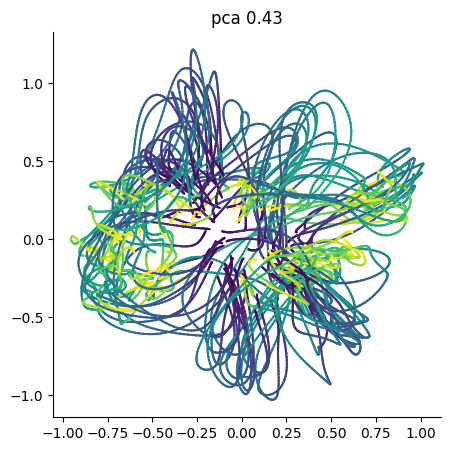

In [6]:
""" PCA """
X_reshaped = np.concatenate(X_pre_pca.swapaxes(1,2))

num_pcs = 6
pca = PCA(num_pcs)
X_pca = pca.fit_transform(X_reshaped)
PCs = pca.components_
X_pca = X_pca.reshape(K, T, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(X_pca)
plt.title(f"pca {var_explained(X_pre_pca, PCs.T):.2f}")

print(np.sum(pca_variance_captured))

#print(np.mean(compute_S(jnp.array(X_pca))))
#print(np.mean(compute_S(jnp.array(X_pca), ratio=False )))
#np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/2_6_2024/single spikes/pca_variance_captured_{num_pcs}d', pca_variance_captured)
#np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/2_6_2024/single spikes/PCs_{num_pcs}d', PCs)
#np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/2_6_2024/single spikes/X_pca_{num_pcs}d', X_pca)

In [7]:
hand_vel = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_eval_behaviour_grouped.npy").swapaxes(1,2)

In [8]:
def get_reg(X_train,y_train,X_test, y_test):
    regr = RidgeCV()
    reg = regr.fit(X_train, y_train)   
    return reg.score(X_test, y_test)   

def principal_angle(Y, X_pca, d, smaller=True):
    Q_A, _ = qr(Y.swapaxes(1,2).reshape(-1,d), mode='reduced')
    Q_B, _ = qr(X_pca.swapaxes(1,2).reshape(-1,d), mode='reduced')
        
    M = np.dot(Q_A.T, Q_B)
        
    _, singular_values, _ = svd(M)
    
    angles = np.arccos(singular_values)
    angles = np.rad2deg(np.sort(angles)[::-1])
    
    if smaller:
        return angles[-1]
    else:
        return angles

In [9]:
ds = np.arange(2,7)

split = 10
lag = 20

ls_r2_sca = []
ls_r2_pca = []
ls_r2_x = []

ls_var_sca = []
#ls_var_pca = []
ls_var_pca = np.cumsum(np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/outputs_cluster/MC_Maze/pca_variance_captured_6d.npy'))[1:]

ls_S_sca = []
ls_S_pca = []

ls_S_numerator_sca = []
ls_S_numerator_pca = []

ls_principal_angle = []
for d in ds:
    y_train = np.concatenate(hand_vel[split:,:,lag:].swapaxes(1,2))
    y_test = np.concatenate(hand_vel[:split,:,lag:].swapaxes(1,2))
    
    U = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/outputs_cluster/MC_Maze/U_psth_{d}d.npy')
    U_qr, _ = jnp.linalg.qr(U)        
    Y = jnp.einsum('ji,kjl->kil', U_qr, X)
    
    X_train_sca = np.concatenate(Y[split:,:,:-lag].swapaxes(1,2))
    X_test_sca = np.concatenate(Y[:split,:,:-lag].swapaxes(1,2))
    ls_r2_sca.append( get_reg(X_train_sca,y_train,X_test_sca, y_test) )
    
    ls_var_sca.append( var_explained(X, U_qr) ) 
    
    ls_S_sca.append( np.mean(compute_S(jnp.array(Y))))
    ls_S_numerator_sca.append(np.mean(compute_S(jnp.array(Y), ratio=False )))

    X_pca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/outputs_cluster/MC_Maze/X_pca_{d}d.npy')
    #PCs = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/2_6_2024/all/PCs_{d}d.npy')
    
    X_train_pca = np.concatenate(X_pca[split:,:,:-lag].swapaxes(1,2))
    X_test_pca = np.concatenate(X_pca[:split,:,:-lag].swapaxes(1,2))
    ls_r2_pca.append( get_reg(X_train_pca,y_train,X_test_pca, y_test) ) 

   # ls_var_pca.append( var_explained(X_pre_pca, PCs.T) ) 
    
    ls_S_pca.append( np.mean(compute_S(jnp.array(X_pca))))
    ls_S_numerator_pca.append(np.mean(compute_S(jnp.array(X_pca), ratio=False )))

    Q_Y, _ = qr(Y.swapaxes(1,2).reshape(-1,d))
    Q_X_pca, _ = qr(X_pca.swapaxes(1,2).reshape(-1,d))
    ls_principal_angle.append( np.rad2deg(subspace_angles(Q_Y, Q_X_pca))[-1] )

X_train = np.concatenate(X[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(X[:split,:,:-lag].swapaxes(1,2))
r2_x = get_reg(X_train,y_train,X_test, y_test) 

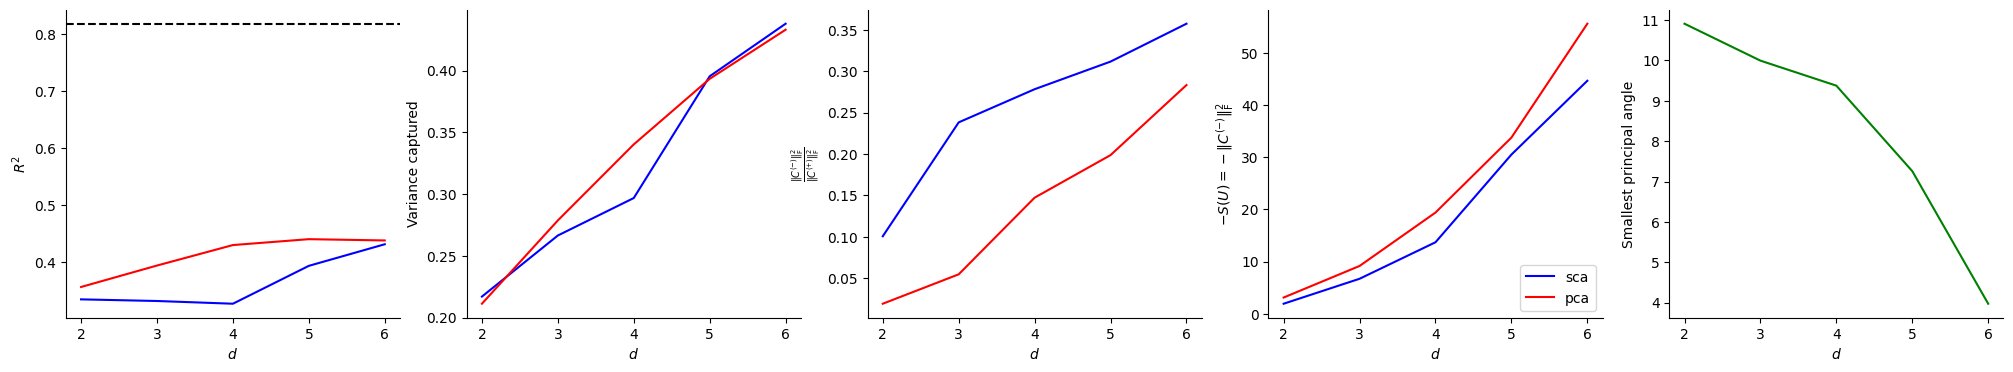

In [10]:
fig, axs = plt.subplots(1,5, figsize=(25,4))

#plt.grid(True)
axs[0].plot(ls_r2_sca, label='sca',color='b')
axs[0].plot(ls_r2_pca, label='pca',color='r')
axs[0].axhline(r2_x, color='black',linestyle='--', label='x')
axs[0].set_xlabel(r"$d$")
axs[0].set_ylabel(r"$R^2$")


axs[1].plot(ls_var_sca, label='sca', color='b')
axs[1].plot(ls_var_pca, label='pca',color='r')
axs[1].set_xlabel(r'$d$')
axs[1].set_ylabel('Variance captured')

axs[2].plot(ls_S_sca, label='sca', color='b')
axs[2].plot(ls_S_pca, label='pca',color='r')
axs[2].set_xlabel(r'$d$')
axs[2].set_ylabel((r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$"))


axs[3].plot(ls_S_numerator_sca, label='sca', color='b')
axs[3].plot(ls_S_numerator_pca, label='pca',color='r')
axs[3].legend(loc='lower right')
axs[3].set_xlabel(r'$d$')
axs[3].set_ylabel(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")

axs[4].plot(ls_principal_angle, color='g')
axs[4].set_xlabel(r'$d$')
axs[4].set_ylabel('Smallest principal angle')

data_length = len(ls_r2_sca) 
tick_positions = np.linspace(0, data_length - 1, num=5) 
tick_labels = np.arange(2, 7) 
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticks(tick_positions, tick_labels)
    #ax.grid()
    


In [9]:
split=10
lag = 20
X_train = np.concatenate(Y[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(Y[:split,:,:-lag].swapaxes(1,2))

y_train = np.concatenate(hand_vel[split:,:,lag:].swapaxes(1,2))
y_test = np.concatenate(hand_vel[:split,:,lag:].swapaxes(1,2))

get_reg(X_train,y_train,X_test, y_test)

0.5485359227487936

In [10]:
X_train = np.concatenate(X_pca[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(X_pca[:split,:,:-lag].swapaxes(1,2))

get_reg(X_train,y_train,X_test, y_test)

0.4380823929700573

In [11]:
X_train = np.concatenate(X[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(X[:split,:,:-lag].swapaxes(1,2))

get_reg(X_train,y_train,X_test, y_test)

0.8232663031666198

ENDS HERE 

In [13]:
d=3
X, _ = pre_processing(X_raw, soft_normalize='max')
U = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/2_6_2024/all/U_psth_3d.npy')
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X)
print(np.mean(compute_S(Y)))

Q_A, _ = qr(Y.swapaxes(1,2).reshape(-1,d), mode='reduced')
Q_B, _ = qr(X_pca.swapaxes(1,2).reshape(-1,d), mode='reduced')
    
M = np.dot(Q_A.T, Q_B)
    
_, singular_values, _ = svd(M)
   
angles = np.arccos(singular_values)
   
np.rad2deg(np.sort(angles)[::-1]  )

0.2927623


array([79.181206, 34.42475 ,  9.955877], dtype=float32)

In [34]:
X, _ = pre_processing(X_raw, soft_normalize='max', pca=True)
d = 10
U = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/SCA_project/outputs/linear_sca/MC_Maze/U_psth_0.001_10000_3d.npy')
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X)
X_pca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/SCA_project/outputs/linear_sca/MC_Maze/29_5_2024/X_pca_10d.npy')

Q_A, _ = qr(Y.swapaxes(1,2).reshape(-1,d))
Q_B, _ = qr(X_pca.swapaxes(1,2).reshape(-1,d))
np.rad2deg( subspace_angles(Q_A, Q_B) )

array([86.69891  , 50.686737 , 30.592262 , 18.307602 , 11.221379 ,
        6.564292 ,  6.0623813,  3.420586 ,  2.2835336,  1.305213 ],
      dtype=float32)